In [21]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob

# Specify the directory containing the .fit files (replace with your actual path)
file_dir = "sun_meas_25/meas_1/"
file_paths = sorted(glob.glob(file_dir + "*.fit"))

# Initialize lists to store combined data and time axis
combined_data = []
time_offset = 0  # To manage time axis across multiple files
time_axes = []  # To concatenate time axes properly

# Loop through each .fit file
for file_path in file_paths:
    hdul = fits.open(file_path)
    
    # Access data (assuming it's a 2D array with shape [frequency, time])
    data = hdul[0].data
    
    # Extract time axis (dummy axis if not provided in the header)
    time_axis = np.arange(data.shape[1]) + time_offset
    time_axes.append(time_axis)
    
    # Append data to the combined list
    combined_data.append(data)
    
    # Update time offset for the next file
    time_offset += data.shape[1]
    
    # Close the file
    hdul.close()

# Concatenate all data and time axes
combined_data = np.hstack(combined_data)  # Combine along the time axis
time_axis_combined = np.hstack(time_axes)  # Combined time axis
freq_axis = np.arange(combined_data.shape[0])  # Dummy frequency axis


# Choose a specific frequency index (modify as needed)
frequency_index = 50  # Example: choose the 50th frequency
chosen_frequency = freq_axis[frequency_index]  # Get the actual frequency value if freq_axis is defined






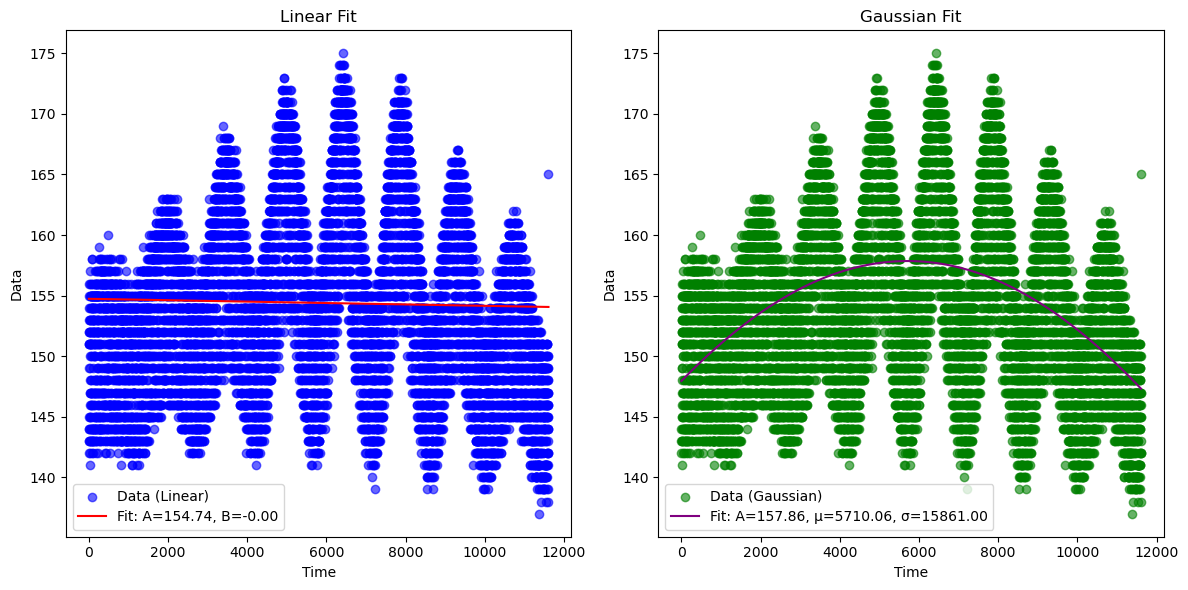

In [22]:
time = time_axis_combined
data = combined_data[frequency_index, :]

def linear(t, A, B):
    return A + B*t

def gaussian(x, A=1, mu=0, sigma=1):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Fit the linear function
linear_params, _ = curve_fit(linear, time, data)
A_linear, B_linear = linear_params

# Generate fitted values for plotting
fitted_linear = linear(time, A_linear, B_linear)


# Fit the Gaussian function (using example Gaussian-like data)
gaussian_params, _ = curve_fit(gaussian, time, data, p0=[3, 5, 1.5])
A_gaussian, mu_gaussian, sigma_gaussian = gaussian_params

# Generate fitted values for plotting
fitted_gaussian = gaussian(time, A_gaussian, mu_gaussian, sigma_gaussian)

# Plot results
plt.figure(figsize=(12, 6))

# Linear plot
plt.subplot(1, 2, 1)
plt.scatter(time, data, label="Data (Linear)", color="blue", alpha=0.6)
plt.plot(time, fitted_linear, label=f"Fit: A={A_linear:.2f}, B={B_linear:.2f}", color="red")
plt.title("Linear Fit")
plt.xlabel("Time")
plt.ylabel("Data")
plt.legend()

# Gaussian plot
plt.subplot(1, 2, 2)
plt.scatter(time, data, label="Data (Gaussian)", color="green", alpha=0.6)
plt.plot(time, fitted_gaussian, label=f"Fit: A={A_gaussian:.2f}, μ={mu_gaussian:.2f}, σ={sigma_gaussian:.2f}", color="purple")
plt.title("Gaussian Fit")
plt.xlabel("Time")
plt.ylabel("Data")
plt.legend()

plt.tight_layout()
plt.show()

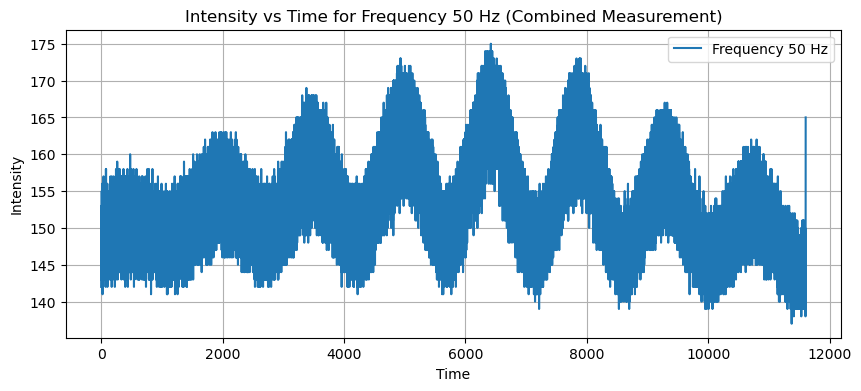

In [23]:
# Plot the intensity of the chosen frequency over the combined time span
plt.figure(figsize=(10, 4))
plt.plot(time_axis_combined, combined_data[frequency_index, :], label=f'Frequency {chosen_frequency} Hz')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Intensity vs Time for Frequency {chosen_frequency} Hz (Combined Measurement)')
plt.legend()
plt.grid(True)
plt.show()